$\textbf{Alternating-Direction-Implicit Method}$

For my final project for AMATH 581, I will be implementing the alternating-direction-implicit method (ADI). The method is outlined here.

For the sake of demonstration, I will consider the Laplace Equation, but this method is a good choice for any Elliplic PDE (eg. Poisson Equation).

$$u_{xx} + u_{yy} = 0$$

Using 2nd order difference scheme for both $u_{xx}$ and $u_{yy}$ and choose $\Delta x = \Delta y = h$, with $N$ points in each direction. We have the following:

$$u(x - h,y) + u(x + h,y) + u(x, y - h) + u(x, y + h) - 4u(x,y)  =0$$

If we discretize our grid so that $x = 0, h, 2h,...$ correspond to $x_i$ and $y = 0, h, 2h,...$ correspond to $y_j$, and $u(x_i, y_j) = u_{i,j}$:

$1)$
\begin{equation}
u_{i - 1,j} + u_{i+1,j} + u_{i, j-1} + u_{i, j+1} - 4u_{i,j}  = 0
\end{equation}

If we put all the terms with index $j$ on one side, we have:

$2)$
$$u_{i - 1,j} - 4u_{i,j} + u_{i+1,j}   = -u_{i, j-1}  -u_{i, j+1}$$

Likewise, we can rearrange $1)$ to put all the terms with index $i$ on the left hand side.

$3)$
$$u_{i,j-1} - 4u_{i,j} + u_{i,j+1}   = -u_{i-1, j}  -u_{i+1, j}$$

$\textbf{Algorithm:}$


Every iteration $m$ of the ADI method, there is two parts. The first part, we will use equation $2)$ to update the grid, and for the second part, we will use equation $3)$ to update the grid. The first update using equation $2)$ is:

$4)$
$$u_{i - 1,j}^{m+1/2} - 4u_{i,j}^{m+1/2} + u_{i+1,j}^{m+1/2}   = -u_{i, j-1}^{m}  -u_{i, j+1}^{m}$$


Here, the superscipts represent the iteration of the solver. For $m+1/2$ step, we set up a system of equations using $4)$ for each of the interior points points along the line horizontal line $y = y_j$ and solve for $u_{1,j}^{m+1/2}, u_{2,j}^{m+1/2},..., u_{N - 1,j}^{m+1/2}$. We do this for each $y_j$.


We then compute the $m^{th}$ step with equation $3)$:

$5)$
$$u_{i,j-1}^{m+1} - 4u_{i,j}^{m+1} + u_{i,j+1}^{m+1}   = -u_{i-1, j}^{m+1/2}  -u_{i+1, j}^{m+1/2}$$

Now we use the equation above for each point along the horizontal line of $x = x_i$ and solve for $u_{i,1}^{m+1},u_{i,2}^{m+1},...,u_{i,N-1}^{m+1}$.  We do this for each $x_i$.

Every time we solve our a system of equations $A \vec{x} = \vec {b}$, the matrix $A$ will be very small compared to the entire grid of points, and have a tri-diagonal shape

$$A  = 	
\begin{bmatrix} 
-4 & 1\\
1 & -4 & 1\\\
& 1& -4 & 1\\
& & & ...
\end{bmatrix}
$$

Although we solve this small $N$ by $N$ many times, compare this method to the direct method of solving for all points in the grid simultaneously, which means solving system with a banded matrix which is $N^2$ by $N^2$. It is clear that in some problems, solving many smaller tridiagonal systems using ADI will be much favorable than solving a single large banded matrix. We can also compare ADI to other iterative methods, like Jacobi iteration or Gauss Seidel, which iteratively solve for each point in the grid, ADI solves iteratively solves for each line of points. In this way, ADI lies somewhere between a iterative solver and a direct solver.

One thing to note, like previous direct solvers we have used for solving PDES, the boundary values are not solved for, and instead, those terms are moved to the right hand side of the matrix equation.

This example was taking from the following paper:
https://iopscience.iop.org/article/10.1088/2399-6528/abbd76/pdf

Consider the following boundary value problem:
 
$$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0 \\
0 < x, y < 4\\
u(x,0) = u(0,y) = u(4,y) = 0\\
u(x,4) = \frac{1}{2}\sin\left( \pi x /4\right)$$

The exact solution is given by:

$$u(x,y) = \frac{1}{2 \sinh(\pi)}\sin \left(\frac{1}{4}\pi x \right) \sinh \left(\frac{1}{4}\pi y \right) $$

I will solve this using the ADI method with $h = 1$ and an initial guess of $u(x,y) = 0$. I will do 15 iterations of this algorithm, and see how each the maximum error compares between the $m^{th}$ iteration and the true solutions.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
pi = np.pi

xi = 0
xf = 4
dx = 1
x = np.arange(xi, xf + dx/2, dx)


yi = 0
yf = 4
dy = dx
y = np.arange(yi, yf + dy/2, dy)

N = len(x)

U = np.zeros((N,N))
U[:,-1] = 0.5*np.sin(0.25*pi*x)



def exact_sol(x,y):
    return np.sin(0.25*pi*x) * np.sinh(0.25*pi*y)/(2*np.sinh(pi))

X,Y = np.meshgrid(x ,y)
U_true = exact_sol(X,Y)

num_iter = 10

errors = np.zeros((1,num_iter))

#A will alwasy look the same when ever we solve:
# -4 on main diagonal, 1's on super/sub diagonal
A = np.diag(np.ones(N - 3), 1) + np.diag(np.ones(N - 3), -1)+ np.diag(-4*np.ones(N-2))

RHS = np.zeros((N-2,1))

for m in range(0, num_iter):
#compute m + 0.5 step
#loop over each row in the grid
    for j in range(1, N-1): #want to loop through the interior points, so 1,2 ,3
        #want to solve the small system for each j being constant
        #need to make RHS
        for i in range(1, N -1): #i should really start at 1, so i am increasing the RHS index to be i + 1
            RHS[i-1,0] = -U[i,j-1] - U[i,j+1]
            if i ==1:
                RHS[i-1,0] = RHS[i-1,0] - U[0,j]
            if i==N-2:
                RHS[i-1,0] = RHS[i-1,0] - U[N-1,j]
        
        sol = np.linalg.solve(A, RHS)
        U[1:N-1,j:(j+1)] = sol
    
    # compute m + 1 step:
    #loop over each column in the grid instead
    for i in range(1, N-1): #want to loop through the interior points, so 1,2 ,3
        #want to solve the small system for each i being constant
        #need to make RHS
        for j in range(1, N -1): #j should really start at 1, so j am increasing the RHS index to be i + 1
            RHS[j-1,0] = -U[i-1,j] - U[i+1,j]
            if j == 1:
                RHS[j-1,0] = RHS[j-1,0] - U[i,0]
            if j == N-2:
                RHS[-1,0] = RHS[-1,0] - U[i,N-1]
        
        sol = np.linalg.solve(A, RHS)
        U[i:(i+1), 1:N-1] = sol.T
        
    U_num = U.T
    errors[0, m] = np.max(np.abs(U_num - U_true))

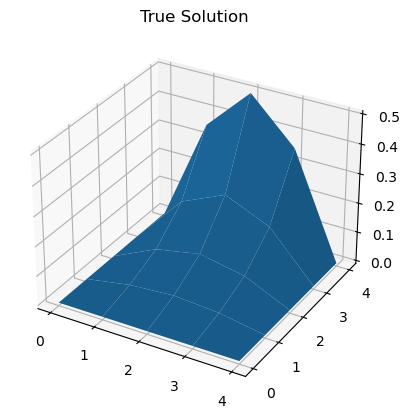

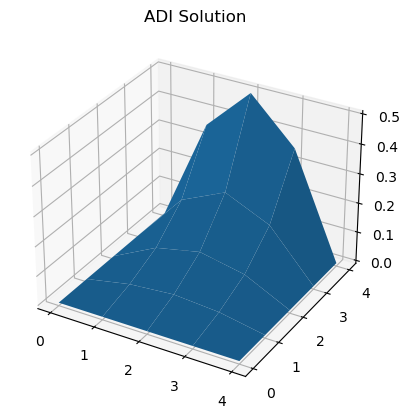

In [3]:
plt.figure()
ax = plt.axes(projection='3d')
# Plot the true solution
ax.plot_surface(X,Y, U_true)
plt.title('True Solution')
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
U_num = U.T
ax.plot_surface(X,Y, U_num)
plt.title('ADI Solution')
plt.show()

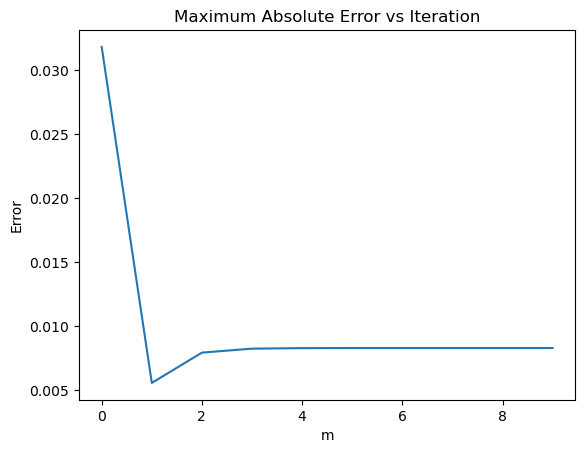

In [7]:
plt.plot(errors[0,:])
plt.title('Maximum Absolute Error vs Iteration')
plt.xlabel('m')
plt.ylabel('Error')
plt.show()

Comparing the ADI solution at m = 10 to the true solution, we can see the solutions look very similar, which is a good sign that the ADI method has been implemented correctly. The plot above shows that with this rough grid, the error does not get any better after m = 2. These results are the same as in the original paper.